# eda (exploratory data analysis)
본 노트에서는 텍스트 데이터를 마주했을 때 해야하는 탐색적 분석 중 하나인 `token_per_sentence`, `total_tokens`를 계산해봅니다. 특히 `token_per_sentence`는 **딥러닝 모형 학습 시 mini-batch 구성을 할 때, padding을 얼마나해야하는 지 확인하는 정보로 활용합니다** 

### Setup

In [1]:
import pandas as pd
from pathlib import Path
from pprint import pprint
from typing import List
%matplotlib inline

### Load dataset

In [2]:
data_dir = Path.cwd() / 'data'
list_of_dataset = list(data_dir.iterdir())
pprint(list_of_dataset)

[WindowsPath('D:/codelab/gantest/strnlp1/exercise/data/morphs_vec.pkl'),
 WindowsPath('D:/codelab/gantest/strnlp1/exercise/data/test.txt'),
 WindowsPath('D:/codelab/gantest/strnlp1/exercise/data/tokenizer.pkl'),
 WindowsPath('D:/codelab/gantest/strnlp1/exercise/data/train.txt'),
 WindowsPath('D:/codelab/gantest/strnlp1/exercise/data/validation.txt'),
 WindowsPath('D:/codelab/gantest/strnlp1/exercise/data/vocab.pkl')]


In [3]:
tr_dataset = pd.read_csv(list_of_dataset[1], sep='\t')
tr_dataset.head()

,document,label
0,굳 ㅋ,1
1,GDNTOPCLASSINTHECLUB,0
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### Define split_fn
token의 집합인 Vocabulary 구성을 위해, 문장을 sequence of tokens의 형태로 split하는 function인 `split_fn`을 작성하거나 기존의 형태소 분석기에서 주어진 함수를 활용해야합니다. **어떤 split_fn을 사용하느냐에 따라 문장의 변형된 결과인 sequence of tokens가 달라집니다. 이에 따라 Vocaburary도 달라집니다.**

In [4]:
example_sentence = '파이콘은 정말 신나는 행사입니다.'

In [5]:
# 문장을 어절기준으로 보는 split_fn을 작성
def split_eojeol(s: str) -> List[str]:
    return s.split(' ')

print(example_sentence, split_eojeol(example_sentence))

파이콘은 정말 신나는 행사입니다. ['파이콘은', '정말', '신나는', '행사입니다.']


In [6]:
# 문장을 형태소기준으로 split
from mecab import MeCab
split_morph = MeCab().morphs
print(example_sentence, split_morph(example_sentence))

파이콘은 정말 신나는 행사입니다. ['파이', '콘', '은', '정말', '신나', '는', '행사', '입니다', '.']


In [14]:
# 문장을 형태소기준으로 split 윈도우일때 하는 방법 추가
import MeCab
mecab_tagger = MeCab.Tagger()

def split_morph(sentence):
    return [
        node.split('\t')[0]
        for node in mecab_tagger.parse(sentence).split('\n')
    ][:-2]

print(example_sentence, split_morph(example_sentence))

파이콘은 정말 신나는 행사입니다. ['파이', '콘', '은', '정말', '신나', '는', '행사', '입니다', '.']


### Calculate `token_per_sentence`, `total_tokens`
위에서 정의한 `MeCab` class의 instance의 멤버함수인 `morphs`를 이용하여 training corpus의 `token_per_sentence`와 `total_tokens`를 계산해봅니다.

In [11]:
length_of_sen = tr_dataset['document'].apply(lambda sen: len(split_morph(sen)))
length_of_sen.describe()

count    49997.000000
mean        18.417265
std         15.425631
min          1.000000
25%          8.000000
50%         14.000000
75%         22.000000
max        105.000000
Name: document, dtype: float64

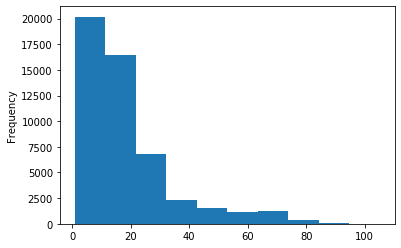

In [12]:
length_of_sen.plot(kind='hist')

In [13]:
total_tokens = length_of_sen.sum()
token_per_sentence = length_of_sen.mean()
print(total_tokens, token_per_sentence)

920808 18.417265035902155


In [15]:
#'pad' -> 길이 맞추기 위해
#'unk' -> 모르는 단어